#  spectra for AuxTel and Equivalent width with Specutils For Holograms

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : April 7th  2021
- update : April 15th 2021 : get equivalent width with specutils, including stat error with bootstrap
- update : April 16th 2021 : write eqw in csv file after correcting important bugs
- update : April 17th 2021 : plot eqw vs time
- version v1.0

# Imports

In [142]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [143]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [144]:
from datetime import datetime,date

In [145]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [146]:
string_date

'2021-04-30'

In [147]:
from iminuit import Minuit
import iminuit

In [148]:
iminuit.__version__

'2.2.0'

In [149]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2

from spectractor.extractor.spectroscopy import O2_1,O2_2,O2B,O2Y,O2Z

                      
from spectractor.extractor.spectroscopy import HYDROGEN_LINES,ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [150]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [151]:
from time import sleep

In [152]:
from astropy.time import Time
import astropy.units as u

# Function

In [153]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Logbook for file selection

In [154]:
filename_logbook='logbooks/auxtellogbook_2021_v1.2.csv'

In [155]:
df=pd.read_csv(filename_logbook,index_col=None)

In [156]:
pd.set_option('display.max_rows', None)

In [157]:
df

,Unnamed: 0,index,date,path,file,num,object,filter,disperser,airmass,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,0,2021-02-17T01:45:09.091,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_RG610_HD50896_2021-02-16_181.fits,181,HD50896,RG610,holo4_003,1.006209,...,10.3,51.0,9.3,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,1,2021-02-17T03:37:12.647,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_empty_HD50896_2021-02-16_209.fits,209,HD50896,empty_1,holo4_003,1.099905,...,10.4,45.0,9.9,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2,2021-02-18T07:25:02.387,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_350.fits,350,NGC4755,empty_1,holo4_003,1.158253,...,8.8,53.0,7.3,750.0,2700.0,NaN,NaN,,1.0,1.0
3,3,3,2021-02-18T07:25:46.560,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_351.fits,351,NGC4755,empty_1,holo4_003,1.158097,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
4,4,4,2021-02-18T07:26:07.146,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_352.fits,352,NGC4755,empty_1,holo4_003,1.158027,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
5,5,5,2021-02-18T07:26:18.957,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_353.fits,353,NGC4755,empty_1,holo4_003,1.157987,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
6,6,6,2021-02-18T07:26:43.049,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_354.fits,354,NGC4755,empty_1,holo4_003,1.157907,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
7,7,7,2021-02-18T07:26:51.615,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_355.fits,355,NGC4755,empty_1,holo4_003,1.157879,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
8,8,8,2021-02-18T07:27:00.190,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_356.fits,356,NGC4755,empty_1,holo4_003,1.157851,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
9,9,9,2021-02-18T07:27:53.863,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_357.fits,357,NGC4755,empty_1,holo4_003,1.157723,...,8.7,55.0,6.7,700.0,1700.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [158]:
df_good=df[df["quality"]==1]

In [159]:
for spectra_file in df_good["file"]:
    print(spectra_file)

Cor_holo4_003_NGC4755_2021-02-17_350.fits
Cor_holo4_003_NGC4755_2021-02-17_351.fits
Cor_holo4_003_NGC4755_2021-02-17_352.fits
Cor_holo4_003_NGC4755_2021-02-17_353.fits
Cor_holo4_003_NGC4755_2021-02-17_354.fits
Cor_holo4_003_NGC4755_2021-02-17_355.fits
Cor_holo4_003_NGC4755_2021-02-17_356.fits
Cor_holo4_003_NGC4755_2021-02-17_357.fits
Cor_holo4_003_NGC4755_2021-02-17_358.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits
Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits
Cor_holo4_003_empty_HD60753_2021-02-18_566.fits
Cor_holo4_003_empty_HD60753_2021-02-18_567.fits
Cor_holo4_003_empty_HD60753_2021-02-18_568.fits
Cor_holo4_003_empty_HD60753_2021-02-18_569.fits
Cor_holo4_003_empty_HD60753_2021-02-18_570.fits
Cor_holo4_003_empty_HD60753_2021-02-18_571.fit

In [160]:
dir_spectra="outputs"

In [161]:
!ls outputs

Cor_holo4_003_NGC4755_2021-02-17_350_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_350_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_350_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_350_table.csv
Cor_holo4_003_NGC4755_2021-02-17_351_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_351_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_351_table.csv
Cor_holo4_003_NGC4755_2021-02-17_352_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_352_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_352_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_352_table.csv
Cor_holo4_003_NGC4755_2021-02-17_353_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_353_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_353_table.csv
Cor_holo4_003_NGC4755_2021-02-17_354_lines.csv
Cor_holo4_003_NGC4755_2021-02-17_354_spectrogram.fits
Cor_holo4_003_NGC4755_2021-02-17_354_spectrum.fits
Cor_holo4_003_NGC4755_2021-02-17_354_table.csv
Cor_h

In [162]:
all_files=os.listdir(dir_spectra)

In [163]:
all_spectra_files = []
for filename in all_files:
    if re.search("_spectrum.fits$",filename):
        all_spectra_files.append(filename)
N=len(all_spectra_files)

In [164]:
all_good_spectra_spectrum_files=[]

idx=0
for good_spectra_file in df_good["file"]:
    good_spectra_spectrum_file = good_spectra_file.split(".")[0]+"_spectrum.fits"
    if good_spectra_spectrum_file in all_spectra_files:
        print(idx,") : found {}".format(good_spectra_spectrum_file))
        all_good_spectra_spectrum_files.append(good_spectra_spectrum_file)
        idx+=1
    

0 ) : found Cor_holo4_003_NGC4755_2021-02-17_350_spectrum.fits
1 ) : found Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits
2 ) : found Cor_holo4_003_NGC4755_2021-02-17_352_spectrum.fits
3 ) : found Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits
4 ) : found Cor_holo4_003_NGC4755_2021-02-17_354_spectrum.fits
5 ) : found Cor_holo4_003_NGC4755_2021-02-17_355_spectrum.fits
6 ) : found Cor_holo4_003_NGC4755_2021-02-17_356_spectrum.fits
7 ) : found Cor_holo4_003_NGC4755_2021-02-17_357_spectrum.fits
8 ) : found Cor_holo4_003_NGC4755_2021-02-17_358_spectrum.fits
9 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_556_spectrum.fits
10 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_559_spectrum.fits
11 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_560_spectrum.fits
12 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_561_spectrum.fits
13 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_562_spectrum.fits
14 ) : found Cor_holo4_003_RG610_HD60753_2021-02-18_563_spectrum.fits
15 ) : found C

In [165]:
index_sel=3
filename=all_good_spectra_spectrum_files[index_sel]
target_name=file_target(filename)[0]

In [166]:
target_name

'NGC4755'

3 ) Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits   outputs/Cor_holo4_003_NGC4755_2021-02-17_353_spectrum.fits


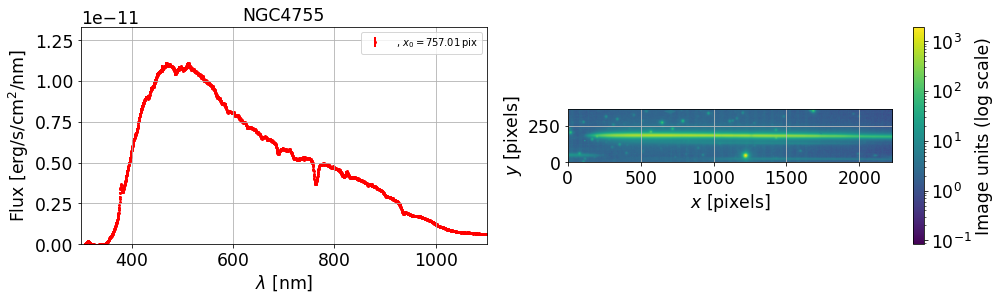

In [167]:
parameters.DISPLAY=False



fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
    
fullfilename = os.path.join(dir_spectra,filename)
    
print(index_sel,")",filename," ",fullfilename)
    

    
s=Spectrum(fullfilename, config="config/auxtel_quicklook.ini")
label=filename.split('.')[0]+" "
s.plot_spectrum(ax=ax1,force_lines=False,label=" ")
    
ax2 = fig.add_subplot(1, 2, 2)
    
fullfilename2=fullfilename.replace("_spectrum","_spectrogram")
    
s.load_spectrogram(fullfilename2)
s.plot_spectrogram(ax=ax2,scale="log")
    
    
plt.show()
    
    

In [168]:
#lines = Lines(ATMOSPHERIC_LINES)
lines = Lines(HYDROGEN_LINES+ATMOSPHERIC_LINES, redshift=0)

In [170]:
for line in ATMOSPHERIC_LINES:
    print(line. wavelength,line.label)

760.3 
763.1 $O_2$
687.472 $O_2(B)$
898.765 $O_2(Y)$
822.696 $O_2(Z)$
935 $H_2 O$
960 $H_2 O$


In [171]:
lines = Lines([O2_1,H2O_1,H2O_2],atmospheric_lines=True, redshift=0, emission_spectrum=False)

In [172]:
s.lines = lines

In [177]:
#MY_O2=[O2_1,O2_2,O2B,O2Y,O2Z]
MY_O2=[O2_1,O2_2,O2B]

In [174]:
lambdas = np.arange(300,1000,1)
fwhm_func = interp1d(lambdas, 0.01 * lambdas)

In [175]:
global_chisq = detect_lines(s.lines, s.lambdas, s.data, s.err, fwhm_func=fwhm_func)

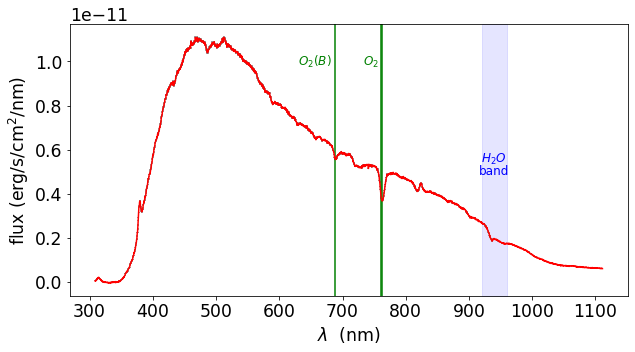

In [187]:
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.errorbar(s.lambdas,s.data,yerr=s.err,fmt='-',color="red",ecolor="grey",label="spectrum")
#ax.plot(s.target.wavelengths[3],s.target.spectra[3],color="blue")

#s.lines.plot_detected_lines(plt.gca())

if len(s.target.spectra) > 0:
    for k in range(len(s.target.spectra)):
        plot_indices = np.logical_and(s.target.wavelengths[k] > np.min(s.lambdas),
                                  s.target.wavelengths[k] < np.max(s.lambdas))
        sf = s.target.spectra[k] / np.max(s.target.spectra[k][plot_indices]) * np.max(s.data)
        wl = s.target.wavelengths[k]
        
        sf_cut=sf[plot_indices]
        wl_cut=wl[plot_indices]
        if k==0:
            ax.plot(wl_cut, sf_cut ,lw=2, color="b",label="SED")
            
            
for line in MY_O2:
    ax.axvline(line.wavelength,color="g")
    ax.text(line.wavelength-5,s.data.max()*.9,line.label, color="g",horizontalalignment='right', verticalalignment='center',fontsize=12)

y_min, y_max = ax.get_ylim()

ax.fill_between(s.lambdas, y_min, y_max, where= np.logical_and(s.lambdas>920,s.lambdas < 960),
                color='blue', alpha=0.1)
ax.text(940,s.data.max()*.5,"$H_2O$", color="b",horizontalalignment='center', verticalalignment='center',fontsize=12)
ax.text(940,s.data.max()*.45,"band", color="b",horizontalalignment='center', verticalalignment='center',fontsize=12)



ax.set_ylim(y_min,y_max)
    
ax.set_xlabel("$\lambda$  (nm)")
ylabel="flux ({})".format(s.units)
ax.set_ylabel(ylabel)
#ax.legend()
#ax.set_title(target_name)
plt.savefig("holospectrum.pdf")